![logo](./img/LogoLine_horizon_CAMS.png)

# Create Animations from CAMS Data

This tutorial demonstrates how to create animations from data of the [Copernicus Atmosphere Monitoring Service (CAMS)](https://atmosphere.copernicus.eu/). We will use as our example Organic Matter Aerosol Optical Depth (AOD) analysis data from the beginning of August 2021 over North America. This was a time of significant wildfire activity.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-cams/master?labpath=04_Animations.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-cams/blob/master/04_Animations.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-cams/blob/master/04_Animations.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<br>

## Install and import packages

In [1]:
!pip install cdsapi

In [26]:
# Import CDS API
import cdsapi

# Libraries for reading and working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries to assist with animation and visualisations
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
import cartopy.crs as ccrs
from IPython.display import HTML

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

## Access and read data

### Data download

Copy your API key into the code cell below, replacing `#######` with your key. (Remember, to access data from the ADS, you will need first to register/login https://ads.atmosphere.copernicus.eu and obtain an API key from https://ads.atmosphere.copernicus.eu/api-how-to.)

In [27]:
URL = 'https://ads.atmosphere.copernicus.eu/api/v2'

# Replace the hashtags with your key:
KEY = '##########################################'

Here we specify a data directory into which we will download our data and all output files that we will generate:

In [28]:
DATADIR = './'

For our first plotting example, we will use CAMS Global Atmospheric Composition Forecast data. The code below shows the subset characteristics that we will extract from this dataset for the purpose of this tutorial as an API request.

```{note}
Before running this code, ensure that you have **accepted the terms and conditions**. This is something you only need to do once for each CAMS dataset. You will find the option to do this by selecting the dataset in the ADS, then scrolling to the end of the *Download data* tab.
```

In [8]:
c = cdsapi.Client(url=URL, key=KEY)
c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'variable': 'organic_matter_aerosol_optical_depth_550nm',
        'date': '2021-08-01/2021-08-08',
        'time': [
            '00:00', '12:00',
        ],
        'leadtime_hour': '0',
        'type': 'forecast',
        'area': [
            80, -150, 25,
            -50,
        ],
        'format': 'netcdf',
    },
    f'{DATADIR}/OAOD_2021-08-01_08.nc')

2022-08-30 20:03:13,550 INFO Welcome to the CDS
2022-08-30 20:03:13,556 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2022-08-30 20:03:13,631 INFO Request is queued
2022-08-30 20:03:14,692 INFO Request is running
2022-08-30 20:03:22,040 INFO Request is completed
2022-08-30 20:03:22,042 INFO Downloading https://download-0000-ads-clone.copernicus-climate.eu/cache-compute-0000/cache/data2/adaptor.mars_constrained.external-1661886138.2765315-1103-10-13617416-4b69-41b8-826c-597fe2846229.nc to ./DATA/OAOD_2021-08-01_08.nc (1.1M)
2022-08-30 20:03:22,862 INFO Download rate 1.3M/s                                                                      


Result(content_length=1111164,content_type=application/x-netcdf,location=https://download-0000-ads-clone.copernicus-climate.eu/cache-compute-0000/cache/data2/adaptor.mars_constrained.external-1661886138.2765315-1103-10-13617416-4b69-41b8-826c-597fe2846229.nc)

### Read data into xarray object

For convenience, we create a variable with the name of our downloaded file:

In [29]:
fn = f'{DATADIR}/OAOD_2021-08-01_08.nc'

Now we can read the data into an xarray *Dataset*, then into a *Data Array*:

In [30]:
# Create Xarray Dataset
ds = xr.open_dataset(fn)
ds

<xarray.Dataset>
Dimensions:    (longitude: 251, latitude: 138, time: 16)
Coordinates:
  * longitude  (longitude) float32 -150.0 -149.6 -149.2 ... -50.8 -50.4 -50.0
  * latitude   (latitude) float32 79.8 79.4 79.0 78.6 ... 26.2 25.8 25.4 25.0
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-08T12:00:00
Data variables:
    omaod550   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-30 19:02:18 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [31]:
# Create Xarray Data Array
da = ds['omaod550']

## Animate data

To visualise the temporal dimension of this data we will create animations, with each frame corresponding to a time step. These include 00:00 and 12:00 at each day from 1 to 8 August. There are several ways to create animations. We will explore two possibilities: In the first example we will simply redraw each frame, and save the output to separate image files from which we will create an animated gif; in the second example we will generate an HTML5 video. 

### Create initial state

To create an animation, we need first to create an initial state for our figure. In our case, this will be a static map showing Organic Matter AOD at the first time step in our data time series.

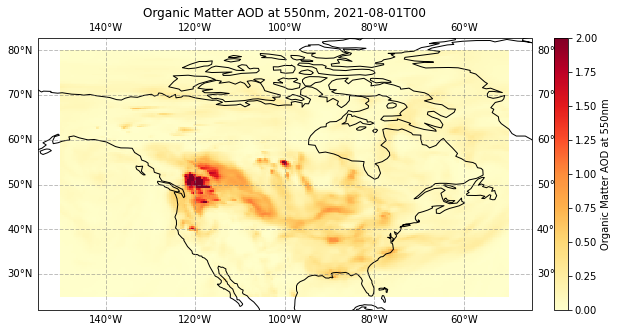

In [32]:
fig = plt.figure(figsize=(10, 5)) # Define the figure and specify size
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree()) # Specify plot area & projection
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') # Add lat/lon grid
ax.set_title(f'Organic Matter AOD at 550nm, {str(da.time[0].values)[:-16]}', fontsize=12) # Set figure title
ax.coastlines(color='black') # Add coastlines
im = plt.pcolormesh(da.longitude, da.latitude, da[0,:,:], cmap='YlOrRd', vmin=0, vmax=2) # Plot the data
cbar = plt.colorbar(im,fraction=0.046, pad=0.04) # Specify the colourbar
cbar.set_label('Organic Matter AOD at 550nm') # Define the colourbar label

This map clearly shows the high values of Organic Matter AOD which appear to originate from the many wildfires burning across North America in this period.

### Set number of frames

We will now create an animation to visualise all time steps. From the description of the dataset above, we see that the time dimension has 16 entries. The number of frames of the animation in our case is therefore 16.

In [33]:
frames = 16

### Create a function that will be called by the animation object

Here create a function that will be called by `FuncAnimation`. It takes one argument, which is the number of frames. `FuncAnimation` will then repeatedly call this function to iterate through the time steps of our data. 

The function includes the data array to loop through. 

We convert the data from an Xarray object to a Numpy array to enable us to flatten it to one dimension for computational efficiency. This is not an essential step (we could just keep the Xarray Data Array, without flattening dimensions), but it speeds up the time taken to produce the animation. 

We also loop through all printed time values in the title of each frame.

In [34]:
def animate(i):
    array = da[i,:,:].values
    im.set_array(array.flatten())
    ax.set_title(f'Organic Matter AOD at 550nm, {str(da.time[i].values)[:-16]}', fontsize=12)

### Create animation object

We now create an animation object by calling `FuncAnimation` with 4 arguments:

1. `fig` is the reference to the figure we created.
2. `animate` is the function to call at each frame to update the plot.
3. `frames` is the number of frames of the animation.
4. `interval` is the time, in milliseconds, between animation frames.

In [40]:
ani = animation.FuncAnimation(fig, animate, frames, interval=150)

### Display animation 

#### Run animation using Javascript

In [41]:
HTML(ani.to_jshtml())

2022-08-30 22:36:54,205 INFO Animation.save using <class 'matplotlib.animation.HTMLWriter'>


The animation shows high values of Organic Matter AOD  on the West coast at the beginning of the time series. Many wildfires were burning across North America in this period. This includes the Dixie fire, which, by August 6, had grown to become the largest single (i.e. non-complex) wildfire in California's history, and the second-largest wildfire overall. 

As the animation progresses, you can see these high values being transported across the continent to affect local air quality as far as the East coast.

#### Run animation as HTML5 video

Another option to run the animation is to convert it into an HTML5 video embeded in the Jupyter Notebook. This requires installation of [FFmpeg](https://ffmpeg.org/).

In [42]:
HTML(ani.to_html5_video())

2022-08-30 22:37:11,403 INFO Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2022-08-30 22:37:11,404 INFO MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 720x360 -pix_fmt rgba -r 6.666666666666667 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'C:\Users\cxcs\AppData\Local\Temp\tmpb4nyxp7f\temp.m4v'


### Save animation

We can save this animation in a number of formats.

#### Save as animated gif

In [43]:
ani.save(f'{DATADIR}/OAOD_2021-08-01_08.gif') # save to animated gif

2022-08-30 22:37:29,978 INFO Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2022-08-30 22:37:29,979 INFO MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 720x360 -pix_fmt rgba -r 6.666666666666667 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y ./DATA/OAOD_2021-08-01_08.gif


#### Save as mp4 video

In [44]:
ani.save(f'{DATADIR}/OAOD_2021-08-01_08.mp4') # save to mp4 video

2022-08-30 22:37:40,645 INFO Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2022-08-30 22:37:40,646 INFO MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 720x360 -pix_fmt rgba -r 6.666666666666667 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./DATA/OAOD_2021-08-01_08.mp4
